In [1]:
from enum import Enum
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def visualize_v_grid(v_grid, env):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Convert V_grid to numpy array for easier manipulation
    v_array = np.array(v_grid)
    
    # Create a mask for zero values (non-accessible states)
    zero_mask = v_array == 0.0
    
    # Create a custom colormap
    cmap = plt.cm.YlGn.copy()
    cmap.set_bad(color='gray')
    
    # Create heatmap
    v_array_masked = np.ma.masked_where(zero_mask, v_array)
    im = ax.imshow(v_array_masked, cmap=cmap)
    
    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Value", rotation=-90, va="bottom")
    
    # Add text annotations
    for i in range(v_array.shape[0]):
        for j in range(v_array.shape[1]):
            if zero_mask[i, j]:
                text = ax.text(j, i, 'X', ha="center", va="center", color="white", fontweight='bold')
            else:
                text = ax.text(j, i, f'{v_array[i, j]:.3f}',
                               ha="center", va="center", color="black")
    
    # Set tick labels
    ax.set_xticks(np.arange(v_array.shape[1]))
    ax.set_yticks(np.arange(v_array.shape[0]))
    ax.set_xticklabels(range(v_array.shape[1]))
    ax.set_yticklabels(range(v_array.shape[0]))
    
    # Add grid
    ax.set_xticks(np.arange(-0.5, v_array.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, v_array.shape[0], 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", va="center")
    
    # Add title
    ax.set_title("Value Function Heatmap")
    
    # Show plot
    plt.tight_layout()
    plt.show()


In [3]:
class CoinToss():

    def __init__(self, head_probs, max_episode_steps=30):
        self.head_probs = head_probs
        self.max_episode_steps = max_episode_steps
        self.toss_count = 0

    def __len__(self):
        return len(self.head_probs)

    def reset(self):
        self.toss_count = 0

    def step(self, action):
        final = self.max_episode_steps - 1
        if self.toss_count > final:
            raise Exception("The step count exceeded maximum. \
                            Please reset env.")
        else:
            done = True if self.toss_count == final else False

        if action >= len(self.head_probs):
            raise Exception("The No.{} coin doesn't exist.".format(action))
        else:
            head_prob = self.head_probs[action]
            if random.random() < head_prob:
                reward = 1.0
            else:
                reward = 0.0
            self.toss_count += 1
            return reward, done

In [4]:
class EpsilonGreedyAgent():

    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.V = []

    def policy(self):
        coins = range(len(self.V))
        if random.random() < self.epsilon:
            return random.choice(coins)
        else:
            return np.argmax(self.V)

    def play(self, env):
        # Initialize estimation.
        N = [0] * len(env)
        self.V = [0] * len(env)

        env.reset()
        done = False
        rewards = []
        while not done:
            selected_coin = self.policy()
            reward, done = env.step(selected_coin)
            rewards.append(reward)

            n = N[selected_coin]
            coin_average = self.V[selected_coin]
            new_average = (coin_average * n + reward) / (n + 1)
            N[selected_coin] += 1
            self.V[selected_coin] = new_average

        return rewards

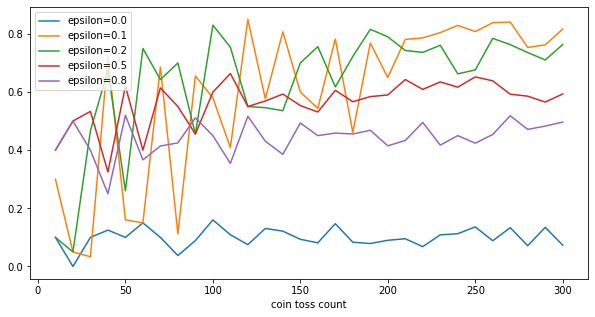

In [5]:
if __name__ == "__main__":
    import pandas as pd
    import matplotlib.pyplot as plt

    def main():
        env = CoinToss([0.1, 0.5, 0.1, 0.9, 0.1])
        epsilons = [0.0, 0.1, 0.2, 0.5, 0.8]
        game_steps = list(range(10, 310, 10))
        result = {}
        for e in epsilons:
            agent = EpsilonGreedyAgent(epsilon=e)
            means = []
            for s in game_steps:
                env.max_episode_steps = s
                rewards = agent.play(env)
                means.append(np.mean(rewards))
            result["epsilon={}".format(e)] = means
        result["coin toss count"] = game_steps
        result = pd.DataFrame(result)
        result.set_index("coin toss count", drop=True, inplace=True)
        result.plot.line(figsize=(10, 5))
        plt.show()

    main()